# Loveida Lucero

# Gridsearch SARIMA Models (Core)
# Zillow Data
You will continue working with Zillow's publicly available Zillow House Value Index (ZHVI) that you prepared for a previous core assignment. https://www.zillow.com/research/data/

- You can start working in the same notebook you used for the Preparing Time Series from Wide-Form Data (Core) assignment
- Specifically, you will be using the Home Value data set for:
  - Data Type = "ZHVI All Homes (SFR+Condo/Coop) - Time Series - Smoothed - Seasonally Adjusted"
  - Geography = "City"
- We have already downloaded the file for you and uploaded it to Google Drive.
  - Share URL: https://drive.google.com/file/d/1O_g44QAfe3uVF-1heAC0BAeVDoWloVR-/view?usp=sharing
  - Direct URL (for Pandas): https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv

## Review: Previous Assignment
In a core assignment from last week (Preparing Time Series from Wide-Form Data (Core)), you worked with this dataset.

- You filtered the data to keep only the 4 largest cities based on their "SizeRank"
- You melted the wide-form data for the 4 largest cities into long-form time series with a datetime index.
- You resampled the data to monthly frequency, grouped by City.
- You performed EDA and answered some questions comparing the cities, including selecting the city that had the highest home value at the end of 2008 and the one that had the lowest value at the end of 2008.


# Time Series Models for Home Values
*Your overall goal is to forecast the home values for the city with the highest home value in 2008(New York) 6months into the future (beyond the dataset).*

- Filter the dataset only to include values starting in 2018
- Check for and address null values.
- Decompose the Time series to detect seasonality and decide if your model should or should not have a seasonal component
- Determine Time Series Model Orders
  - Check the time series for stationarity.
    - Determine the number of differencing needed to make the data stationary
  - Check the ACF/PACF Plots of the differenced data to determine the orders
- Split the time series into training and test data (Remember we want to predict 6 months, and our data has been resampled to monthly)
- Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
  - Make forecasts with your model.
  - Plot the forecasts versus the test data
  - Obtain metrics for evaluation
- Tune with pmdarima's auto_arima
  - Fit a model on training data with the best parameters from auto_arima
  - Obtain metrics for evaluation
  - Make forecasts with the auto_arima model
  - Plot the forecasts versus the test data
- Select your final model
- Make true future forecasts using the entire dataset (for dates beyond the entire ts).
  - Calculate the predicted net change in home value for the forecasted period as both:
    - Raw values for change in the final month in the forecast vs. the first month.
    - Convert the raw delta into a percent change.

**Answer the following questions in a Markdown cell**

- What is the predicted home value in New York City 6 months into the future (beyond the dataset)?
- What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?


# SOLUTION

**Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)

## Customization Options,
plt.style.use(('ggplot','fivethirtyeight'))
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
sns.set_context('notebook', font_scale=1.2)

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

**Custom Functions**

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
#    ax.set_ylabel('Adjusted Closing Price')
    ax.legend();
    
    return fig, ax

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
import matplotlib.dates as mdates
def plot_seasonal(seasonal):
    minor_loc = mdates.MonthLocator()
    fig, ax = plt.subplots()
    ax.plot(seasonal)
    ax.set(title='Seasonal Component for New York');
    ax.xaxis.set_minor_locator(minor_loc)
    ax.grid(which='major', axis='x',lw=1, color='k')
    ax.grid(which='minor',axis='x',lw=0.5)
    fig.autofmt_xdate(rotation=90, ha='center')

    return fig, ax

In [7]:
df = pd.read_csv('Data/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22467 entries, 0 to 22466
Columns: 281 entries, RegionID to 2022-09-30
dtypes: float64(273), int64(2), object(6)
memory usage: 48.2+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


# Previous Assignment Prep isolating New York

In [8]:
# filter 4 largest cities
cities_filter = df['SizeRank']<= 3
df = df[cities_filter]
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [9]:
# melt columns to long form
melted = pd.melt(df.drop(columns=['RegionID','SizeRank','Metro',
                                  'CountyName','RegionType','StateName',
                                  'State','RegionID','SizeRank',]),
                 id_vars=['RegionName'],
                 value_name='IndexValue',
                var_name='Date')
melted

,RegionName,Date,IndexValue
0,New York,2000-01-31,253690.0
1,Los Angeles,2000-01-31,234181.0
2,Houston,2000-01-31,109068.0
3,Chicago,2000-01-31,166139.0
4,New York,2000-02-29,255517.0
...,...,...,...
1087,Chicago,2022-08-31,315587.0
1088,New York,2022-09-30,781622.0
1089,Los Angeles,2022-09-30,966595.0
1090,Houston,2022-09-30,272639.0


In [10]:
# change date to datetime 
melted['Date'] = pd.to_datetime(melted['Date'])
# set date as index
melted = melted.set_index("Date")
melted

,RegionName,IndexValue
Date,,
2000-01-31,New York,253690.0
2000-01-31,Los Angeles,234181.0
2000-01-31,Houston,109068.0
2000-01-31,Chicago,166139.0
2000-02-29,New York,255517.0
...,...,...
2022-08-31,Chicago,315587.0
2022-09-30,New York,781622.0
2022-09-30,Los Angeles,966595.0


In [11]:
df_ny = melted[melted['RegionName']=='New York']
df_ny

,RegionName,IndexValue
Date,,
2000-01-31,New York,253690.0
2000-02-29,New York,255517.0
2000-03-31,New York,257207.0
2000-04-30,New York,260310.0
2000-05-31,New York,263204.0
...,...,...
2022-05-31,New York,768797.0
2022-06-30,New York,773944.0
2022-07-31,New York,777692.0


In [12]:
# groupby by city and set freq to monthly
df_ts = df_ny.groupby('RegionName').resample("MS").sum()
df_ts

C:\Users\Lovei\AppData\Local\Temp\ipykernel_32636\2041984472.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ts = df_ny.groupby('RegionName').resample("MS").sum()


IndexValue
RegionName Date                  
New York   2000-01-01    253690.0
           2000-02-01    255517.0
           2000-03-01    257207.0
           2000-04-01    260310.0
           2000-05-01    263204.0
...                           ...
           2022-05-01    768797.0
           2022-06-01    773944.0
           2022-07-01    777692.0
           2022-08-01    779960.0
           2022-09-01    781622.0

[273 rows x 1 columns]

In [13]:
# create unstacked df
unstacked = df_ts.unstack(level=0)
unstacked

,IndexValue
RegionName,New York
Date,
2000-01-01,253690.0
2000-02-01,255517.0
2000-03-01,257207.0
2000-04-01,260310.0
2000-05-01,263204.0
...,...
2022-05-01,768797.0
2022-06-01,773944.0


In [14]:
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatter
fmt_thous = mticks.FuncFormatter(thousands)

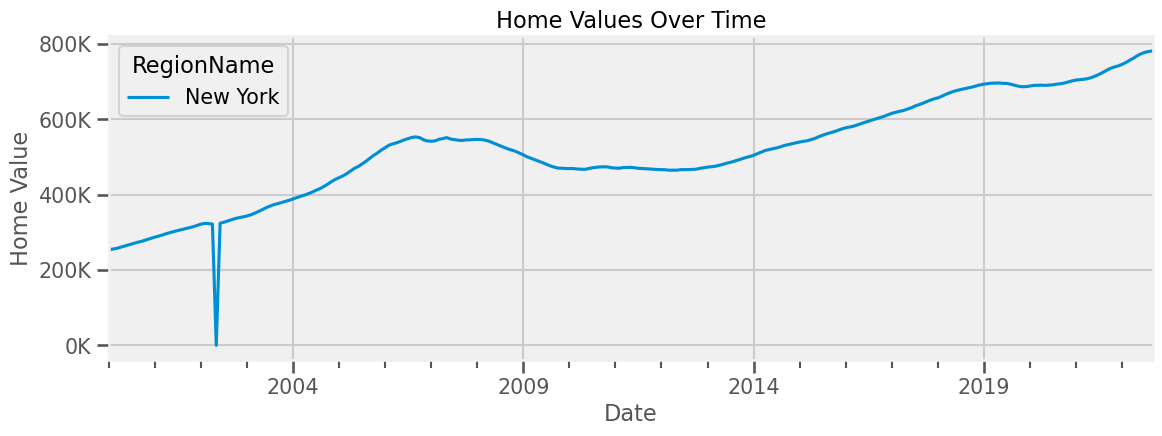

In [15]:
ax = unstacked['IndexValue'].plot()
ax.set_ylabel('Home Value')
ax.set_title('Home Values Over Time')

fmt_thous = mticks.FuncFormatter(thousands)
ax.yaxis.set_major_formatter(fmt_thous)

## Filter the dataset only to include values starting in 2018

In [16]:
# filter years 2018 and greater
unstacked_filtered = unstacked.loc['2018':]
unstacked_filtered

,IndexValue
RegionName,New York
Date,
2018-01-01,656700.0
2018-02-01,661012.0
2018-03-01,665672.0
2018-04-01,669989.0
2018-05-01,673514.0
2018-06-01,676434.0
2018-07-01,678984.0
2018-08-01,681140.0


In [17]:
ts = unstacked_filtered['IndexValue']
ts = ts['New York']
ts

Date
2018-01-01    656700.0
2018-02-01    661012.0
2018-03-01    665672.0
2018-04-01    669989.0
2018-05-01    673514.0
2018-06-01    676434.0
2018-07-01    678984.0
2018-08-01    681140.0
2018-09-01    683546.0
2018-10-01    685588.0
2018-11-01    688553.0
2018-12-01    691226.0
2019-01-01    693208.0
2019-02-01    694425.0
2019-03-01    695720.0
2019-04-01    695824.0
2019-05-01    696173.0
2019-06-01    695186.0
2019-07-01    695010.0
2019-08-01    692926.0
2019-09-01    690189.0
2019-10-01    687693.0
2019-11-01    686304.0
2019-12-01    686650.0
2020-01-01    688073.0
2020-02-01    689697.0
2020-03-01    690055.0
2020-04-01    690520.0
2020-05-01    689921.0
2020-06-01    690785.0
2020-07-01    691384.0
2020-08-01    693097.0
2020-09-01    694261.0
2020-10-01    696260.0
2020-11-01    698929.0
2020-12-01    701899.0
2021-01-01    703956.0
2021-02-01    705003.0
2021-03-01    706066.0
2021-04-01    707633.0
2021-05-01    710706.0
2021-06-01    714507.0
2021-07-01    719155.0
2021-0

## Check for and address null values

In [18]:
ts.isna().sum().sum()

0

## Decompose the Time series to detect seasonality and decide if your model should or should not have a seasonal component

In [19]:
decomp = tsa.seasonal_decompose(ts)
decomp

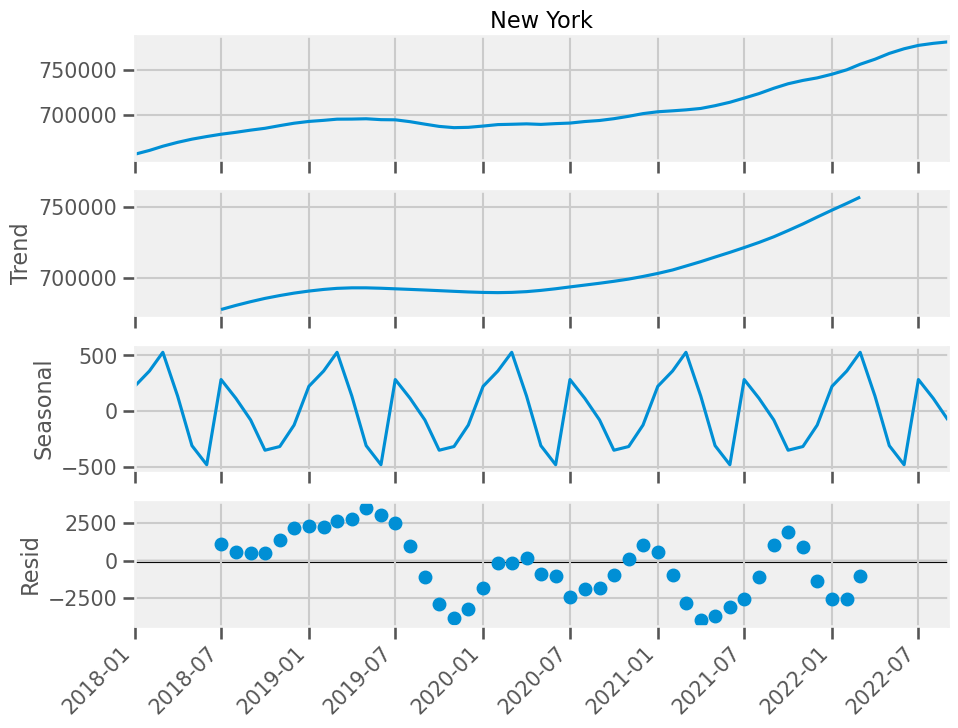

In [20]:
# vizualize decomp
plt.rcParams['figure.figsize']=(10,8)

fig = decomp.plot()

# customize major ticks 
major_loc =  mdates.YearLocator(1)
major_fmt = mdates.DateFormatter("%Y")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize='large',fontweight='bold' ) 
ax.xaxis.set_major_locator(major_loc)
ax.xaxis.set_major_formatter(major_fmt)

fig.tight_layout()
fig.autofmt_xdate(which='major', rotation=45);

In [21]:
from scipy.signal import find_peaks
seasonal = decomp.seasonal
peaks, props = find_peaks(seasonal, height=seasonal.max())

In [22]:
peak_dates = seasonal.index[peaks]
peak_dates

DatetimeIndex(['2018-03-01', '2019-03-01', '2020-03-01', '2021-03-01',
               '2022-03-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [23]:
period = peak_dates[1] - peak_dates[0]
period

Timedelta('365 days 00:00:00')

In [24]:
periods = []
for i in range(len(peak_dates)-1):
    delta = peak_dates[i+1] - peak_dates[i]
    periods.append(delta)
periods

[Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00')]

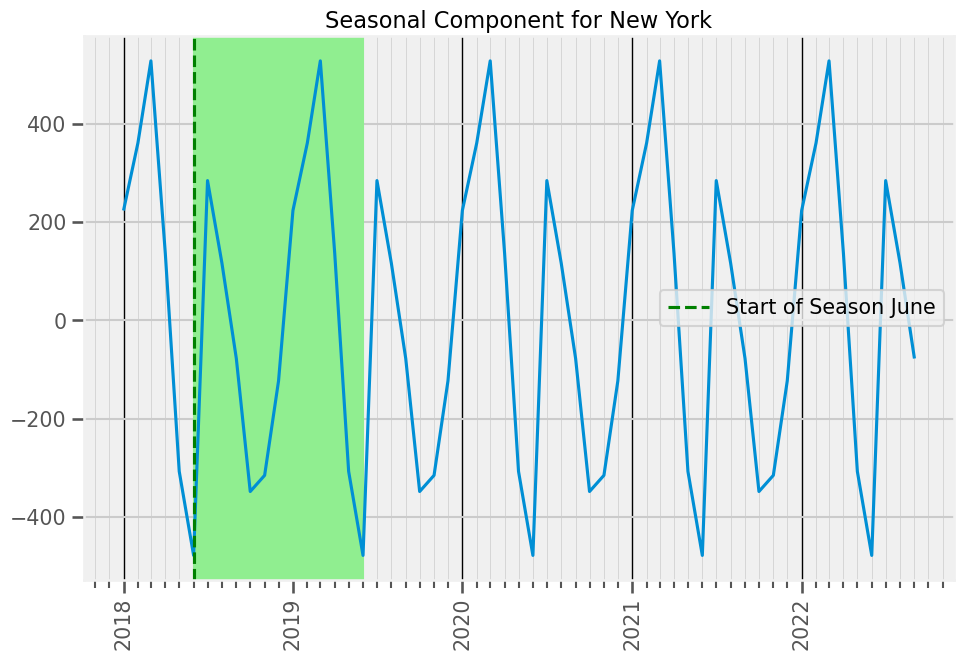

In [25]:
fig, ax = plot_seasonal(seasonal)
season_start = seasonal.idxmin()
ax.axvspan( season_start, season_start +period, color='lightgreen')
ax.axvline(season_start, color='green', ls='--',
           label=f"Start of Season {season_start.strftime('%B')}")
ax.legend();

In [26]:
seasonal.max() - seasonal.min()

1006.1319444444575

- The seasonality has too high a variance to be needed in the model.

## - Determine Time Series Model Orders
##    - Check the time series for stationarity.
##    - Determine the number of differencing needed to make the data stationary
## - Check the ACF/PACF Plots of the differenced data to determine the orders

In [27]:
# tsa.adfuller(df)
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [28]:
# obtain diff number
ndiffs(ts)

2

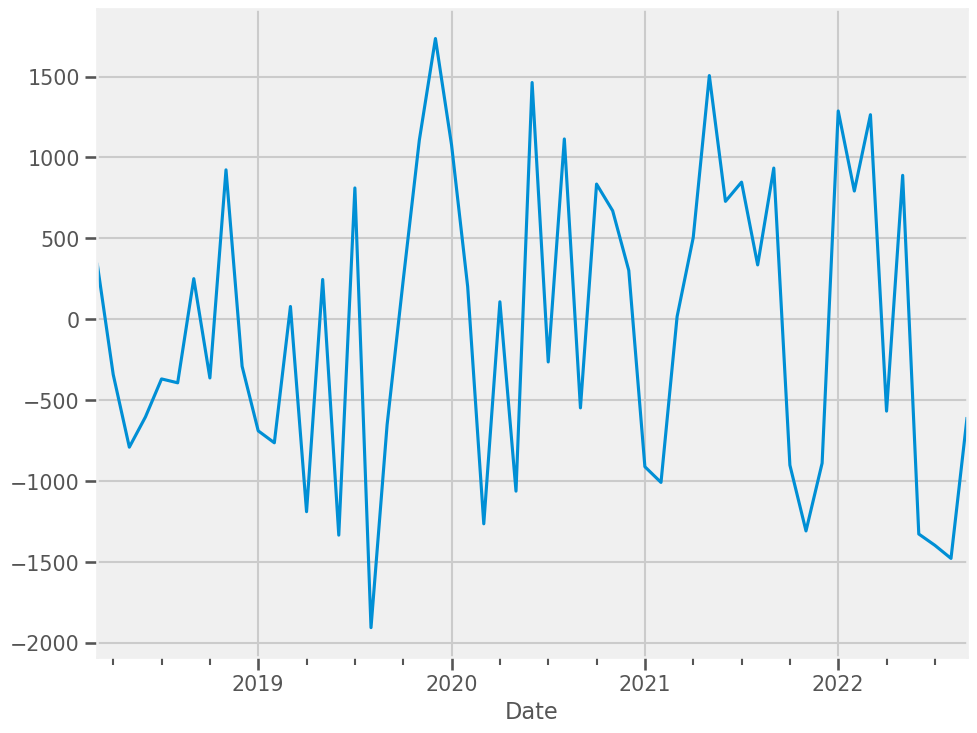

In [29]:
# define new df with 2 diffs
df_diff2 = ts.diff().diff()
df_diff2 = df_diff2.dropna()

#plot new df
df_diff2.plot();

In [30]:
# confirm 2diff is stationary
get_adfuller_results(df_diff2)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.461615,2,52,0.000003,0.05,True


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 40 must be < 27.

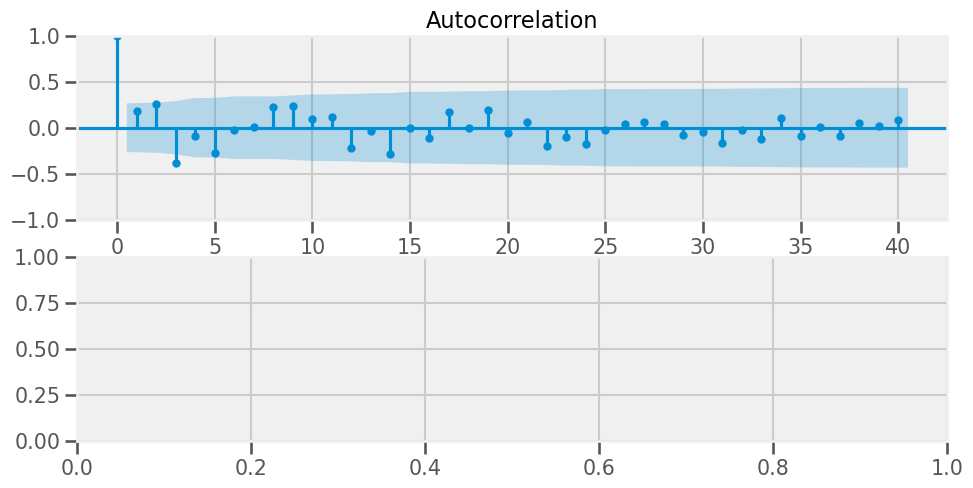

In [31]:
# plot acf to determine p,q,d
plot_acf_pacf(df_diff2);